# Training

In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
device = torch.device("cuda")
np.random.seed(seed=33)

if True:
  deeplab_resnet101 = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)

normalize3 = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalize1 = torchvision.transforms.Normalize(mean=[0.485], std=[0.229])
transforms3 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize3])
transforms1 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize1])

In [0]:
rgb_data = Image.open('/content/gdrive/My Drive/Potsdam/top_potsdam_2_10_RGB.tif')
elevation_data = Image.open('/content/gdrive/My Drive/Potsdam/dsm_potsdam_02_10_normalized_lastools.jpg')
label_data = Image.open('/content/gdrive/My Drive/Potsdam/top_potsdam_2_10_label.tif')

In [0]:
def transmute_to_classes(window):
  # 2 = tree
  # 3 = ground
  # 4 = clutter
  # 1 = building
  # 5 = car
  # 0 = everything else
  retval = (4*(window[:, :, 0]/0xff).astype(np.long) + 2*(window[:, :, 1]/0xff).astype(np.long) + 1*(window[:, :, 2]/0xff).astype(np.long))
  retval = retval * (retval < 6)
  return retval

def random_potsdam_training_window(rgb_data, elevation_data, label_data):
  size = 224
  x = np.random.randint(0, 6000 - size)
  y = np.random.randint(0, 6000 - size)
  box = (x, y, x + size, y + size)
  rgb_window = rgb_data.crop(box)
  elevation_window = elevation_data.crop(box)
  labels_window = np.array(label_data.crop(box))
  labels_window = transmute_to_classes(labels_window)
  return (rgb_window, elevation_window, labels_window)

def random_potsdam_training_batch(rgb_ar, elevation_ar, labels_ar):
  batch_size = 16
  
  rgbs = []
  elvs = []
  labs = []
  
  for i in range(batch_size):
    rgb, elv, lab = random_potsdam_training_window(rgb_ar, elevation_ar, labels_ar)

    rgbs.append(transforms3(rgb))
    elvs.append(transforms1(elv))
    labs.append(torch.unsqueeze(torch.from_numpy(lab), 0))

  rgbs = torch.stack(rgbs).to(device)
  elvs = torch.stack(elvs).to(device)
  labs = torch.cat(labs, dim=0).to(device)

  return (rgbs, elvs, labs)


In [0]:
# Reshape Network for 6 Classes

last_class = deeplab_resnet101.classifier[4] = torch.nn.Conv2d(256, 6, kernel_size=(1,1), stride=(1,1))
last_class_aux = deeplab_resnet101.aux_classifier[4] = torch.nn.Conv2d(256, 6, kernel_size=(1,1), stride=(1,1))

deeplab_resnet101 = deeplab_resnet101.to(device)

In [0]:
# Feature Extraction Only

if False:
  for p in deeplab_resnet101.parameters():
    p.requires_grad = False

  for p in last_class.parameters():
    p.requires_grad = True

  for p in last_class_aux.parameters():
    p.requires_grad = True


In [0]:
# Optimizer

ps = []
for n, p in deeplab_resnet101.named_parameters():
  if p.requires_grad == True:
    ps.append(p)
    
opt = torch.optim.SGD(ps, lr=0.01, momentum=0.9)

In [0]:
# Objective Function

obj = torch.nn.CrossEntropyLoss().to(device)

In [0]:
# Get a Batch

if True:
  import time

  before = time.time()
  batch_tensor = random_potsdam_training_batch(rgb_data, elevation_data, label_data)
  after = time.time()
  print(after - before)

In [0]:
# Train for One Step

if True:
  opt.zero_grad()
  pred = deeplab_resnet101(batch_tensor[0])
  loss = obj(pred.get('out'), batch_tensor[2])
  loss.backward()
  opt.step()

In [0]:
# Train

import time
import math

steps_per_epoch_per_image = int((6000 * 6000) / (224 * 224 * 16))
epochs = 20

deeplab_resnet101.train()
for i in range(epochs):
  for j in range(steps_per_epoch_per_image):
    batch_tensor = random_potsdam_training_batch(rgb_data, elevation_data, label_data)
    opt.zero_grad()
    pred = deeplab_resnet101(batch_tensor[0])
    loss = obj(pred.get('out'), batch_tensor[2]) + 0.4*obj(pred.get('aux'), batch_tensor[2])
    loss.backward()
    opt.step()
  print('epoch={} time={} loss={}'.format(i, time.time(), loss.item()))

epoch=0 time=1562874983.6363654 loss=0.6757434606552124
epoch=1 time=1562875069.6152744 loss=0.504688024520874
epoch=2 time=1562875155.5746934 loss=0.4898879826068878
epoch=3 time=1562875241.2384515 loss=0.3509546220302582
epoch=4 time=1562875327.0958748 loss=0.29970741271972656
epoch=5 time=1562875412.991119 loss=0.377235472202301
epoch=6 time=1562875498.8401685 loss=0.3496016561985016
epoch=7 time=1562875584.7385159 loss=0.19868335127830505
epoch=8 time=1562875670.677632 loss=0.19164811074733734
epoch=9 time=1562875756.601745 loss=0.29606056213378906
epoch=10 time=1562875842.477473 loss=0.28578171133995056
epoch=11 time=1562875928.402611 loss=0.2993726134300232
epoch=12 time=1562876014.3374288 loss=0.14951224625110626
epoch=13 time=1562876100.2066114 loss=0.11831024289131165
epoch=14 time=1562876186.108881 loss=0.24582549929618835
epoch=15 time=1562876272.0515678 loss=0.12952390313148499
epoch=16 time=1562876358.0058775 loss=0.13071653246879578
epoch=17 time=1562876443.964641 loss=0.

# Eval

In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
device = torch.device("cuda")
np.random.seed(seed=33)

if True:
  deeplab_resnet101 = torch.load('/content/gdrive/My Drive/Potsdam/deeplab_resnet101_fe.pth')

normalize3 = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
normalize1 = torchvision.transforms.Normalize(mean=[0.485], std=[0.229])
transforms3 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize3])
transforms1 = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize1])

In [0]:
rgb_data = Image.open('/content/gdrive/My Drive/Potsdam/top_potsdam_2_10_RGB.tif')
elevation_data = Image.open('/content/gdrive/My Drive/Potsdam/dsm_potsdam_02_10_normalized_lastools.jpg')
label_data = Image.open('/content/gdrive/My Drive/Potsdam/top_potsdam_2_10_label.tif')

In [0]:
def transmute_to_classes(window):
  # 2 = tree
  # 3 = ground
  # 4 = clutter
  # 1 = building
  # 5 = car
  # 0 = everything else
  retval = (4*(window[:, :, 0]/0xff).astype(np.long) + 2*(window[:, :, 1]/0xff).astype(np.long) + 1*(window[:, :, 2]/0xff).astype(np.long))
  retval = retval * (retval < 6)
  return retval

def random_potsdam_training_window(rgb_data, elevation_data, label_data):
  size = 224
  x = np.random.randint(0, 6000 - size)
  y = np.random.randint(0, 6000 - size)
  box = (x, y, x + size, y + size)
  rgb_window = rgb_data.crop(box)
  elevation_window = elevation_data.crop(box)
  labels_window = np.array(label_data.crop(box))
  labels_window = transmute_to_classes(labels_window)
  return (rgb_window, elevation_window, labels_window)

def random_potsdam_training_batch(rgb_ar, elevation_ar, labels_ar):
  batch_size = 64
  
  rgbs = []
  elvs = []
  labs = []
  
  for i in range(batch_size):
    rgb, elv, lab = random_potsdam_training_window(rgb_ar, elevation_ar, labels_ar)

    rgbs.append(transforms3(rgb))
    elvs.append(transforms1(elv))
    labs.append(torch.unsqueeze(torch.from_numpy(lab), 0))

  rgbs = torch.stack(rgbs).to(device)
  elvs = torch.stack(elvs).to(device)
  labs = torch.cat(labs, dim=0).to(device)

  return (rgbs, elvs, labs)


In [0]:
# Get a Batch

batch_tensor = random_potsdam_training_batch(rgb_data, elevation_data, label_data)


In [0]:
deeplab_resnet101.eval()
out = deeplab_resnet101(batch_tensor[0])
out = out['out'].data.cpu().numpy()
out.shape

(16, 6, 224, 224)

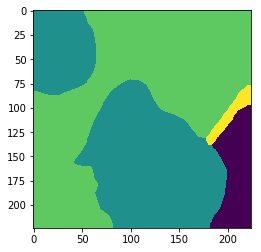

In [0]:
index = 13
predicted_segments = np.apply_along_axis(np.argmax, 0, out[index])
plt.imshow(predicted_segments)

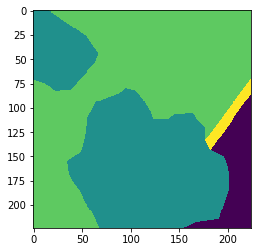

In [0]:
groundtruth_segments = batch_tensor[2].data.cpu().numpy()[index]
plt.imshow(groundtruth_segments)

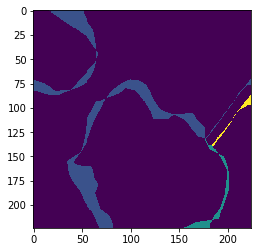

In [0]:
plt.imshow(np.fabs(predicted_segments - groundtruth_segments))